In [1]:
import numpy as np
from matplotlib import pyplot as plt

import numpy.linalg as la
import os

In [2]:
def rk4(f, y0, T, N):
    # f(t_n, y_n) -> y'_n
    # y0 = Initial value
    # T = Final value of t, t varies from 0 to T inclusive
    # N = number of steps
    y = np.array(y0, dtype=float)
    h = float(T)/N
    ts = np.linspace(0, T, N+1)

    out = np.empty(shape=(N+1,y.shape[0]), dtype=float)

    for i, t in enumerate(ts[:-1]):
        out[i] = y
        k1 = f(t, y)
        k2 = f(t+0.5*h, y + 0.5*h*k1)
        k3 = f(t+0.5*h, y + 0.5*h*k2)
        k4 = f(t+h, y + h*k3)
        y += h* 1/6.0 * (k1 + k2+k2 + k3+k3 + k4)
    
    out[N] = y

    return out

In [3]:
n = 5

T = 10.
N = 100

L = 10.
k = 5.
m = 2.
a0 = 0
w0 = 0
aL = 0
wL = 0

In [4]:
def f(t,y):
    A = np.zeros(shape=(n,n), dtype=float)
    for i in range(n):
        A[i,i] = 2*k/m
    for i in range(n-1):
        A[i,i+1] = -1*k/m
        A[i+1,i] = -1*k/m

    zeros = np.zeros_like(A)
    mat = np.block([[zeros, np.identity(n, dtype=float)], [-A, zeros]])

    g = np.zeros(shape=(n,), dtype=float)
    g[0] = (k/m) * a0 * np.sin(w0 * t)
    g[n-1] = (k/m) * (L + aL * np.sin(wL * t))

    b = np.concatenate([np.zeros_like(g),g])

    return np.matmul(mat,y) + b

In [5]:
def plot_masses(out, ts):
    plt.figure()
    for i in range(n):
        plt.plot(ts, out[:,i])
    plt.xlabel('t') # Label x axis
    plt.ylabel('x(t)') # Label x axis
    plt.axis((0, T, -1.5*abs(a0), L + 1.5*abs(aL)))
    plt.show() # Finish and show the plot

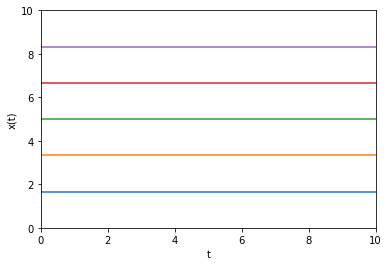

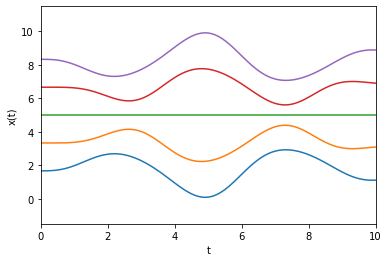

Accuracy ratio = 14.428872940947784


In [6]:
def p2():
    x0 = (L/(n+1)) * np.linspace(1,n,n)
    v0 = np.zeros_like(x0)
    y0 = np.concatenate([x0, v0])

    ts = np.linspace(0, T, N+1)

    global a0, w0, aL, wL

    a0 = w0 = aL = wL = 0
    out = rk4(f, y0, T, N)
    plot_masses(out, ts)

    a0 = w0 = wL = 1
    aL = -1
    out = rk4(f, y0, T, N)
    plot_masses(out, ts)

    N100 = rk4(f, y0, T, 100)[100,0]
    N200 = rk4(f, y0, T, 200)[200,0]
    N400 = rk4(f, y0, T, 400)[400,0]

    print(f'Accuracy ratio = {(N200 - N100)/(N400 - N200)}')
    
p2()

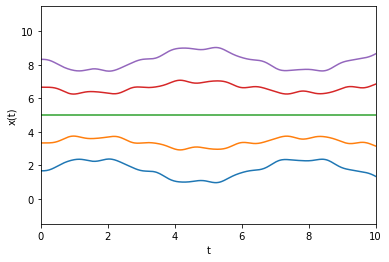

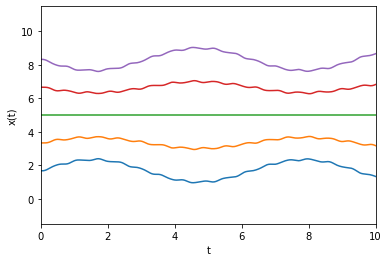

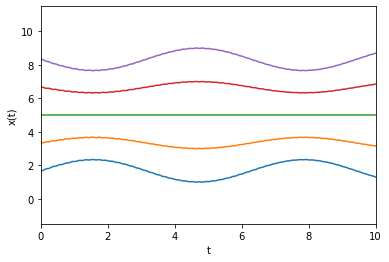

In [7]:
def p3abc():
    x0 = (L/(n+1)) * np.linspace(1,n,n)
    v0 = np.zeros_like(x0)
    y0 = np.concatenate([x0, v0])

    ts = np.linspace(0, T, 400+1)

    global a0, w0, aL, wL, k
    a0 = w0 = wL = 1
    aL = -1
    
    k = 50
    plot_masses(rk4(f, y0, T, 400), ts)
    
    k = 200
    plot_masses(rk4(f, y0, T, 400), ts)
    
    k = 2000
    plot_masses(rk4(f, y0, T, 400), ts)
    
p3abc()

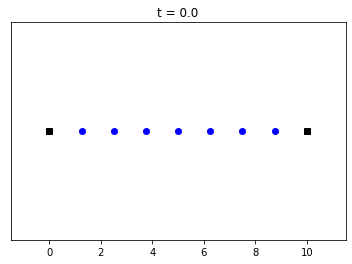

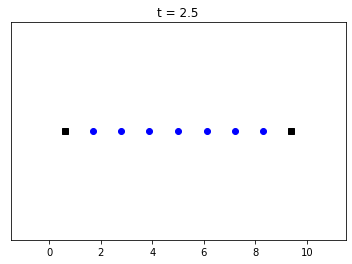

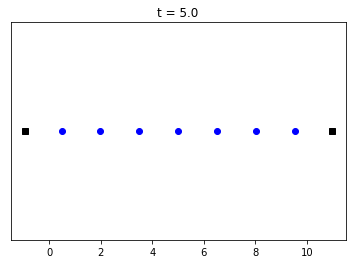

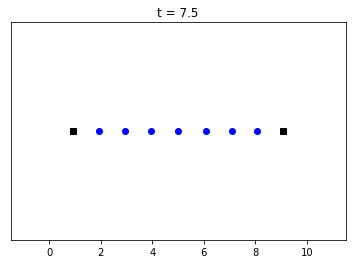

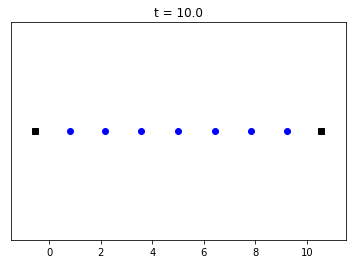

In [8]:
def p4():
    global n
    n = 7

    x0 = (L/(n+1)) * np.linspace(1,n,n)
    v0 = np.zeros_like(x0)
    y0 = np.concatenate([x0, v0])

    ts = np.linspace(0, T, 400+1)

    global a0, w0, aL, wL, k
    a0 = w0 = wL = 1
    aL = -1
    k = 200

    os.system("mkdir temp_images/") 
    os.system("rm temp_images/*.png")
    
    out = rk4(f, y0, T, 400)

    ts_4 = np.linspace(0,T,100+1)
    for i, ys in enumerate(out[::4, :n]):
        t = ts_4[i]
        fig = plt.figure()
        plt.plot(ys,ys*0,'bo')
        plt.plot(np.array([a0*np.sin(w0*t),L+aL*np.sin(wL*t)]),np.array([0,0]),'ks')
        d = (L+aL)/10
        plt.axis((-1.5*abs(a0), L + 1.5*abs(aL), -1, 1))
        plt.gca().get_yaxis().set_visible(False)
        plt.title('t = '+str(round(t,2)))
        plt.savefig("temp_images/image" + str(i).zfill(4) + ".png")
        if (i % 25 == 0):
            plt.show()
        plt.close()

    os.system("ffmpeg -y -framerate 30 -i temp_images/image%04d.png -c:v libx264 -vf \"scale=trunc(iw/2)*2:trunc(ih/2)*2\" -pix_fmt yuv420p movie.mp4")

p4()

In [9]:
def p5ab():
    global a0, w0, aL, wL, k
    a0 = w0 = wL = 1
    aL = -1
    k = 200

    def Ej(vjs):
        coeffs = np.full_like(vjs,4, dtype=float)  # [4,4,4,4,4,...,4,4,4,4,4]
        coeffs[::2] = 2  # [2,4,2,4,2,...,2,4,2,4,2]
        coeffs[0] = 1  # [1,4,2,4,2,...,2,4,2,4,2]
        coeffs[-1] = 1  # [1,4,2,4,2,...,2,4,2,4,1]

        h3 = T/(3.0*vjs.shape[0])   # h/3

        return h3 * np.dot((m/2)*vjs**2, coeffs)

    x0 = (L/(n+1)) * np.linspace(1,n,n)
    v0 = np.zeros_like(x0)
    y0 = np.concatenate([x0, v0])
    
    out = rk4(f, y0, T, 400)

    Ejs = np.empty(shape=(n,), dtype=float)
    for j in range(n):
        Ejs[j] = Ej(out[:, n+j])
    
    plt.figure()
    plt.plot(np.arange(n), Ejs, 'bo')
    plt.ylabel('$E_j$')
    plt.xlabel('j-th mass')
    plt.xticks(np.arange(n, step=5))
    plt.title('Mean kinetic energy')

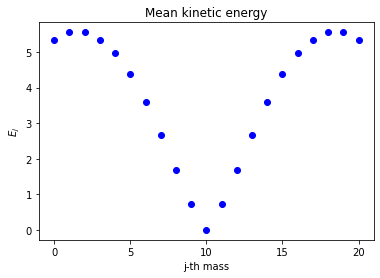

In [10]:
def p5a():
    global n
    n = 21
    p5ab()
    
p5a()

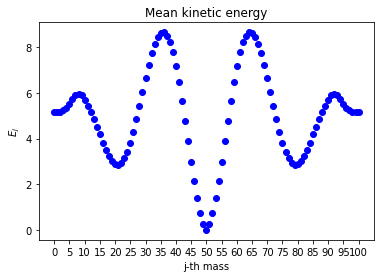

In [11]:
def p5b():
    global n
    n = 101
    p5ab()

p5b()

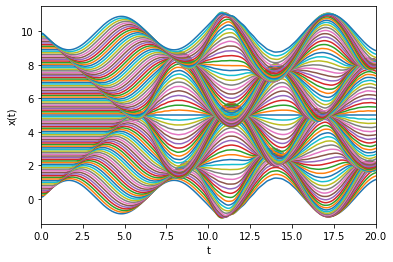

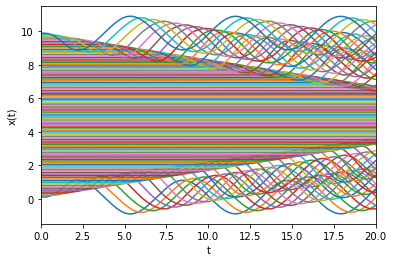

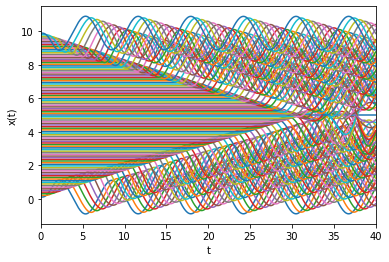

In [12]:
def p6abc():
    global a0, w0, aL, wL, k, n
    a0 = w0 = wL = 1
    aL = -1
    n = 101

    x0 = (L/(n+1)) * np.linspace(1,n,n)
    v0 = np.zeros_like(x0)
    y0 = np.concatenate([x0, v0])
    
    out = rk4(f, y0, T, 400)

    plot_masses(out, np.linspace(0, T, 400+1))

def p6():
    global T, k, N

    T = 20
    N = 800
    k = 200
    p6abc()

    k = 5
    p6abc()

    T = 40
    N = 1600
    p6abc()

p6()

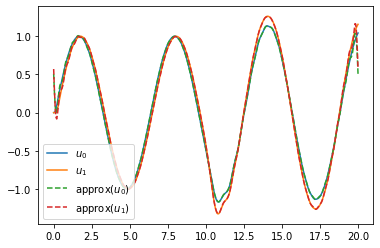

In [13]:
def p7():
    global a0, w0, aL, wL, k, n, T, k
    a0 = w0 = wL = 1
    aL = -1
    n = 101
    k = 200

    T = 20
    N = 800

    x0 = (L/(n+1)) * np.linspace(1,n,n)
    v0 = np.zeros_like(x0)
    y0 = np.concatenate([x0, v0])

    ts = np.linspace(0, T, 400+1)
    
    out = rk4(f, y0, T, 400)

    ujs = np.copy(out[:,:n])
    ujs -= ujs[0, :]

    simp_coeffs = np.full_like(ujs[:,0],4, dtype=float)  # [4,4,4,4,4,...,4,4,4,4,4]
    simp_coeffs[::2] = 2  # [2,4,2,4,2,...,2,4,2,4,2]
    simp_coeffs[0] = simp_coeffs[-1] = 1  # [1,4,2,4,2,...,2,4,2,4,2]

    h3T = 1/(3.0*simp_coeffs.shape[0])   # h/3T

    def cjm(J,m):
        ys = np.exp(-2 * np.pi * 1j * m * ts / T) * ujs[:, J]
        return h3T * np.dot(ys, simp_coeffs)

    ms = np.linspace(np.floor(n/2), -np.floor(n/2), n)
    c1ms = [cjm(0,m) for m in ms]
    c2ms = [cjm(1,m) for m in ms]

    def f_u1(t):
        es = np.exp(2 * np.pi * 1j * ms * t / T)
        return np.real(np.dot(c1ms, es))

    def f_u2(t):
        es = np.exp(2 * np.pi * 1j * ms * t / T)
        return np.real(np.dot(c2ms, es))

    plt.figure()
    plt.plot(ts, ujs[:,0], '-')
    plt.plot(ts, ujs[:,1], '-')
    plt.plot(ts, [f_u1(t) for t in ts], '--')
    plt.plot(ts, [f_u2(t) for t in ts], '--')
    plt.legend(['$u_0$', '$u_1$', 'approx($u_0$)', 'approx($u_1$)'])
    plt.show()

p7()